# W5 Project -Regression

**Background**: You are working as an analyst for a real estate company. Your company wants to build a machine learning model to predict the selling prices of houses based on a variety of features on which the value of the house is evaluated.

**Objective**: The task is to build a model that will predict the price of a house based on features provided in the dataset. The senior management also wants to explore the characteristics of the houses using some business intelligence tool. One of those parameters include understanding which factors are responsible for higher property value - \$650K and above.
The questions have been provided later in the document for which you can use tableau.

# 1. Import libraries

In [1]:
import sqlalchemy
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
#sns.set_style("whitegrid")

from scipy.stats import skew

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split

from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import getpass  # To get the password without showing the input
password = getpass.getpass()

········


# 2. Establishing the connection with MySQL and getting a Panda's dataframe (df) called "data" out of a MySQL query

In [2]:
connection_string = 'mysql+pymysql://root:' + password + '@localhost/house_price_regression'
engine = create_engine(connection_string)

# 3. Importing Data from SQL Queries 

In [3]:
query = 'select * from house_price_regression.house_price_data;'

data_import = pd.read_sql_query(query, engine)
data_import

,house_id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,views,house_condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,latitude,longitude,sqft_living15,sqft_lot15,price
0,1000102,6,3.00,2400,9373,2.0,0,0,3,7,2400,0,1991,0,98002,47.3262,-122.214,2060,7316,280000
1,100100050,3,1.00,1320,11090,1.0,0,0,3,7,1320,0,1955,0,98155,47.7748,-122.304,1320,8319,275000
2,1001200035,3,1.00,1350,7973,1.5,0,0,3,7,1350,0,1954,0,98188,47.4323,-122.292,1310,7491,272450
3,1001200050,4,1.50,1260,7248,1.5,0,0,5,7,1260,0,1955,0,98188,47.4330,-122.292,1300,7732,259000
4,1003000175,3,1.00,980,7606,1.0,0,0,3,7,980,0,1954,0,98188,47.4356,-122.290,980,8125,221000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21415,993002177,3,2.50,1380,1547,3.0,0,0,3,8,1380,0,2000,0,98103,47.6908,-122.341,1380,1465,345000
21416,993002225,3,2.25,1520,1245,3.0,0,0,3,8,1520,0,2004,0,98103,47.6907,-122.340,1520,1470,405000
21417,993002247,3,2.25,1550,1469,3.0,0,0,3,8,1550,0,2004,0,98103,47.6911,-122.341,1520,1465,430000
21418,993002325,2,1.50,950,4625,1.0,0,0,4,7,950,0,1949,0,98103,47.6912,-122.340,1440,4625,430000


# 4. Clean Data

In [4]:
print("DATA SHAPE IS: ", data_import.shape)
print("")
print ("DATA DTYPES ARE: ") 
data_import.dtypes

DATA SHAPE IS:  (21420, 20)

DATA DTYPES ARE: 


house_id            object
bedrooms             int64
bathrooms          float64
sqft_living          int64
sqft_lot             int64
floors             float64
waterfront           int64
views                int64
house_condition      int64
grade                int64
sqft_above           int64
sqft_basement        int64
yr_built            object
yr_renovated        object
zipcode             object
latitude           float64
longitude          float64
sqft_living15        int64
sqft_lot15           int64
price                int64
dtype: object

In [5]:
data_import.nunique()

house_id           21420
bedrooms              12
bathrooms             29
sqft_living         1034
sqft_lot            9776
floors                 6
waterfront             2
views                  5
house_condition        5
grade                 11
sqft_above           942
sqft_basement        306
yr_built             116
yr_renovated          70
zipcode               70
latitude            5033
longitude            751
sqft_living15        777
sqft_lot15          8682
price               3607
dtype: int64

#### It can already be seen that house_id are all unique values and will not add any value to the model, but the information will be necessary because we need to know for which house we are predicting the price. Therefore house_id will be moved to the index position.

In [6]:
data = data_import.set_index(data_import['house_id'])
data = data.drop(['house_id'], axis=1)
data.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,views,house_condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,latitude,longitude,sqft_living15,sqft_lot15,price
house_id,,,,,,,,,,,,,,,,,,,
1000102,6,3.0,2400,9373,2.0,0,0,3,7,2400,0,1991,0,98002,47.3262,-122.214,2060,7316,280000
100100050,3,1.0,1320,11090,1.0,0,0,3,7,1320,0,1955,0,98155,47.7748,-122.304,1320,8319,275000
1001200035,3,1.0,1350,7973,1.5,0,0,3,7,1350,0,1954,0,98188,47.4323,-122.292,1310,7491,272450
1001200050,4,1.5,1260,7248,1.5,0,0,5,7,1260,0,1955,0,98188,47.4330,-122.292,1300,7732,259000
1003000175,3,1.0,980,7606,1.0,0,0,3,7,980,0,1954,0,98188,47.4356,-122.290,980,8125,221000


#### Changing necessary dtypes

In [7]:
data[['yr_built', 'yr_renovated']] = data[['yr_built', 'yr_renovated']].astype('int64')

In [8]:
data.dtypes

bedrooms             int64
bathrooms          float64
sqft_living          int64
sqft_lot             int64
floors             float64
waterfront           int64
views                int64
house_condition      int64
grade                int64
sqft_above           int64
sqft_basement        int64
yr_built             int64
yr_renovated         int64
zipcode             object
latitude           float64
longitude          float64
sqft_living15        int64
sqft_lot15           int64
price                int64
dtype: object

#### Checking for NA's

In [9]:
data.isnull().sum()

bedrooms           0
bathrooms          0
sqft_living        0
sqft_lot           0
floors             0
waterfront         0
views              0
house_condition    0
grade              0
sqft_above         0
sqft_basement      0
yr_built           0
yr_renovated       0
zipcode            0
latitude           0
longitude          0
sqft_living15      0
sqft_lot15         0
price              0
dtype: int64

In [10]:
data.isna().sum()

bedrooms           0
bathrooms          0
sqft_living        0
sqft_lot           0
floors             0
waterfront         0
views              0
house_condition    0
grade              0
sqft_above         0
sqft_basement      0
yr_built           0
yr_renovated       0
zipcode            0
latitude           0
longitude          0
sqft_living15      0
sqft_lot15         0
price              0
dtype: int64

The dataframe was quite clean, there are no null values.

#### Feature engineering
I will create a column showing 1 if the house has a basement and 0 if it doesn't. In doing so, I can drop sqft_basement and sqft_above. I'm interested in the total square footage of the house and whether it has a basement or not.
From previous tests I see that dropping the following columns improves the models significantly.
Zipcode will be the location variable over latitude and longitude. sqft_living15 and sqft_lot15 showed a high correlation with sqft_living and sqft_plot in previous tests. I consider them dispensable.

In [11]:
data['basement']=np.where(data_import['sqft_basement'] != 0, 1, data_import['sqft_basement'])
data = data.drop(['sqft_basement', 'sqft_above', 'latitude', 'longitude', 'sqft_living15', 'sqft_lot15'], axis=1)

In [12]:
data.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,views,house_condition,grade,yr_built,yr_renovated,zipcode,price,basement
house_id,,,,,,,,,,,,,,
1000102,6,3.0,2400,9373,2.0,0,0,3,7,1991,0,98002,280000,0
100100050,3,1.0,1320,11090,1.0,0,0,3,7,1955,0,98155,275000,0
1001200035,3,1.0,1350,7973,1.5,0,0,3,7,1954,0,98188,272450,0
1001200050,4,1.5,1260,7248,1.5,0,0,5,7,1955,0,98188,259000,0
1003000175,3,1.0,980,7606,1.0,0,0,3,7,1954,0,98188,221000,0


# 5. Data exploration

#### Dividing data into categorical, numerical, discrete and continuous

In [13]:
cat_df = data.select_dtypes(include=np.object)
num_df = data.select_dtypes(include=np.number)
disc_df = data[['bedrooms','bathrooms','floors','waterfront','views','house_condition','grade','yr_built','yr_renovated']]
cont_df = data[['sqft_living','sqft_lot','price']]

In [14]:
cat_df.head(5)

,zipcode
house_id,
1000102,98002
100100050,98155
1001200035,98188
1001200050,98188
1003000175,98188


In [15]:
num_df.head(5)

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,views,house_condition,grade,yr_built,yr_renovated,price,basement
house_id,,,,,,,,,,,,,
1000102,6,3.0,2400,9373,2.0,0,0,3,7,1991,0,280000,0
100100050,3,1.0,1320,11090,1.0,0,0,3,7,1955,0,275000,0
1001200035,3,1.0,1350,7973,1.5,0,0,3,7,1954,0,272450,0
1001200050,4,1.5,1260,7248,1.5,0,0,5,7,1955,0,259000,0
1003000175,3,1.0,980,7606,1.0,0,0,3,7,1954,0,221000,0


In [16]:
disc_df.head(5)

,bedrooms,bathrooms,floors,waterfront,views,house_condition,grade,yr_built,yr_renovated
house_id,,,,,,,,,
1000102,6,3.0,2.0,0,0,3,7,1991,0
100100050,3,1.0,1.0,0,0,3,7,1955,0
1001200035,3,1.0,1.5,0,0,3,7,1954,0
1001200050,4,1.5,1.5,0,0,5,7,1955,0
1003000175,3,1.0,1.0,0,0,3,7,1954,0


In [17]:
cont_df.head(5)

,sqft_living,sqft_lot,price
house_id,,,
1000102,2400,9373,280000
100100050,1320,11090,275000
1001200035,1350,7973,272450
1001200050,1260,7248,259000
1003000175,980,7606,221000


## Numerical columns

#### Getting basic statistical summary of the numerical columns

In [18]:
num_df.describe()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,views,house_condition,grade,yr_built,yr_renovated,price,basement
count,21420.000000,21420.000000,21420.000000,2.142000e+04,21420.000000,21420.000000,21420.000000,21420.000000,21420.000000,21420.000000,21420.000000,2.142000e+04,21420.000000
mean,3.373950,2.118429,2083.132633,1.512804e+04,1.495985,0.007610,0.235107,3.410784,7.662792,1971.092997,84.793091,5.407393e+05,0.393137
std,0.925405,0.768720,918.808412,4.153080e+04,0.540081,0.086903,0.767165,0.650035,1.171971,29.387141,402.574626,3.679311e+05,0.488458
min,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,3.000000,1900.000000,0.000000,7.800000e+04,0.000000
25%,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1952.000000,0.000000,3.225000e+05,0.000000
50%,3.000000,2.250000,1920.000000,7.614000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1975.000000,0.000000,4.500000e+05,0.000000
75%,4.000000,2.500000,2550.000000,1.069050e+04,2.000000,0.000000,0.000000,4.000000,8.000000,1997.000000,0.000000,6.450000e+05,1.000000
max,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,2015.000000,2015.000000,7.700000e+06,1.000000


#### Checking for correlation

In [19]:
num_df.corr()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,views,house_condition,grade,yr_built,yr_renovated,price,basement
bedrooms,1.000000,0.515383,0.579069,0.032490,0.177734,-0.006940,0.080019,0.025893,0.357988,0.155241,0.017977,0.309453,0.161433
bathrooms,0.515383,1.000000,0.755522,0.087779,0.501803,0.063734,0.187336,-0.129362,0.665587,0.506252,0.050904,0.526229,0.162598
sqft_living,0.579069,0.755522,1.000000,0.172586,0.352868,0.103938,0.283851,-0.061677,0.762477,0.316646,0.055028,0.701875,0.203382
sqft_lot,0.032490,0.087779,0.172586,1.000000,-0.005561,0.021599,0.075203,-0.009169,0.113656,0.052312,0.007679,0.089111,-0.035506
floors,0.177734,0.501803,0.352868,-0.005561,1.000000,0.023530,0.027575,-0.266859,0.458091,0.488935,0.005714,0.256286,-0.257003
waterfront,-0.006940,0.063734,0.103938,0.021599,0.023530,1.000000,0.403140,0.016564,0.082955,-0.026529,0.093013,0.266991,0.037306
views,0.080019,0.187336,0.283851,0.075203,0.027575,0.403140,1.000000,0.045059,0.250298,-0.055351,0.103667,0.397008,0.181797
house_condition,0.025893,-0.129362,-0.061677,-0.009169,-0.266859,0.016564,0.045059,1.000000,-0.150508,-0.365129,-0.061308,0.034779,0.135687
grade,0.357988,0.665587,0.762477,0.113656,0.458091,0.082955,0.250298,-0.150508,1.000000,0.446235,0.014201,0.668020,0.049801
yr_built,0.155241,0.506252,0.316646,0.052312,0.488935,-0.026529,-0.055351,-0.365129,0.446235,1.000000,-0.225731,0.052906,-0.168879


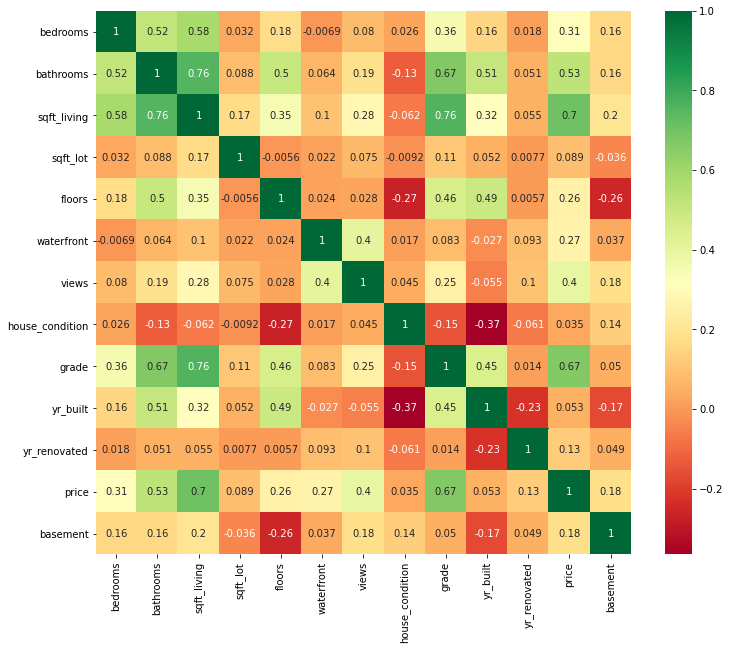

In [20]:
corr_matrix=num_df.corr(method='pearson')  # default
fig, ax = plt.subplots(figsize=(12, 10))
ax = sns.heatmap(corr_matrix, annot=True, cmap="RdYlGn")  #YlGnBu
plt.savefig('plot.png', dpi=300, bbox_inches='tight')
plt.show()

##### We can find high correlation between sqft_living and bathrooms; grade and bathrooms. To keep in mind...

### Checking for outliers

In [21]:
num_df.describe()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,views,house_condition,grade,yr_built,yr_renovated,price,basement
count,21420.000000,21420.000000,21420.000000,2.142000e+04,21420.000000,21420.000000,21420.000000,21420.000000,21420.000000,21420.000000,21420.000000,2.142000e+04,21420.000000
mean,3.373950,2.118429,2083.132633,1.512804e+04,1.495985,0.007610,0.235107,3.410784,7.662792,1971.092997,84.793091,5.407393e+05,0.393137
std,0.925405,0.768720,918.808412,4.153080e+04,0.540081,0.086903,0.767165,0.650035,1.171971,29.387141,402.574626,3.679311e+05,0.488458
min,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,3.000000,1900.000000,0.000000,7.800000e+04,0.000000
25%,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1952.000000,0.000000,3.225000e+05,0.000000
50%,3.000000,2.250000,1920.000000,7.614000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1975.000000,0.000000,4.500000e+05,0.000000
75%,4.000000,2.500000,2550.000000,1.069050e+04,2.000000,0.000000,0.000000,4.000000,8.000000,1997.000000,0.000000,6.450000e+05,1.000000
max,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,2015.000000,2015.000000,7.700000e+06,1.000000


C:\Users\yelam\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


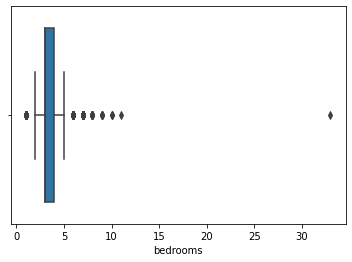

C:\Users\yelam\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


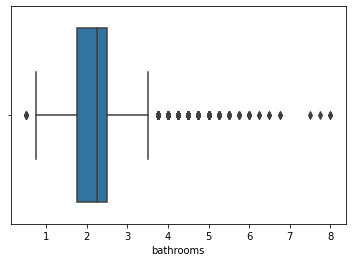

C:\Users\yelam\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


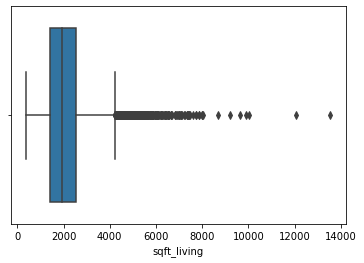

C:\Users\yelam\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


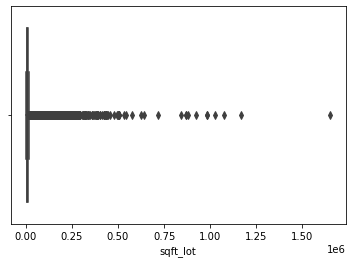

C:\Users\yelam\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


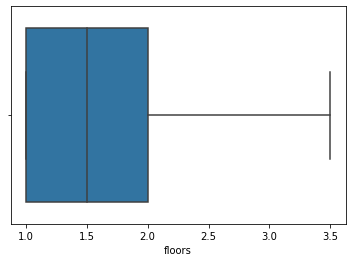

C:\Users\yelam\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


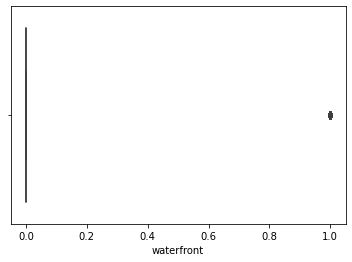

C:\Users\yelam\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


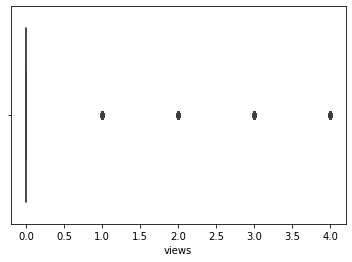

C:\Users\yelam\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


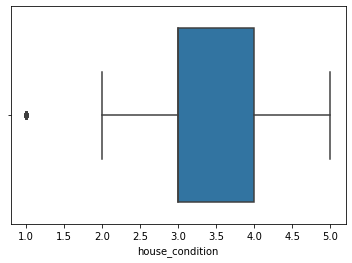

C:\Users\yelam\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


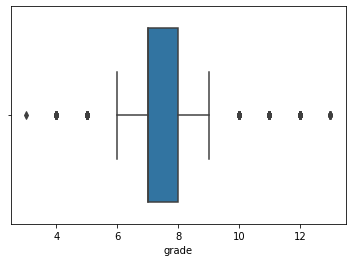

C:\Users\yelam\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


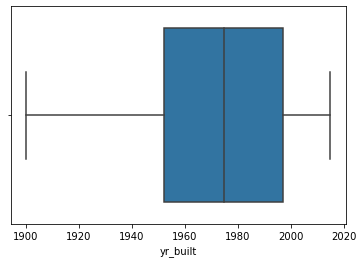

C:\Users\yelam\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


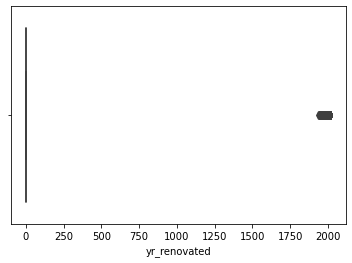

C:\Users\yelam\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


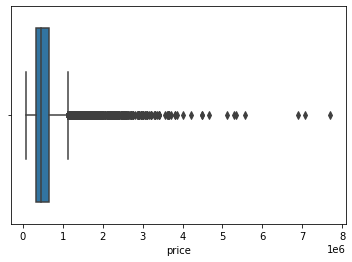

C:\Users\yelam\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


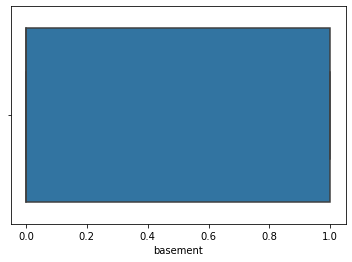

In [22]:
for i in num_df.columns:
    sns.boxplot(num_df[i])
    plt.show()

In [23]:
len(cont_df)

21420

In [24]:
Q1 = num_df.quantile(0.25)
Q3 = num_df.quantile(0.75)
IQR = Q3 - Q1

Checking how many outliers there are per column. I can compare with the length of cont_df.

In [25]:
((num_df < (Q1 - 1.5 * IQR)) | (num_df > (Q3 + 1.5 * IQR))).sum()

bedrooms            518
bathrooms           558
sqft_living         568
sqft_lot           2406
floors                0
waterfront          163
views              2114
house_condition      28
grade              1889
yr_built              0
yr_renovated        910
price              1151
basement              0
dtype: int64

##### The previous method does not take into account the lower whiskers. Let's check how many outliers we really have:

In [31]:
outlier_df = num_df.drop(['floors', 'yr_built', 'yr_renovated', 'basement'], axis=1)

In [32]:
for col in outlier_df.columns:
    iqr = np.percentile(outlier_df[col],75) - np.percentile(outlier_df[col],25)
    upper_limit = np.percentile(outlier_df[col],75) + 1.5*iqr
    lower_limit = np.percentile(outlier_df[col],75) - 1.5*iqr
    print("For column {}:".format(col))
    print("the upper wisker is at: %4.2f" % upper_limit)
    print("the lower wisker is at: %4.2f" % lower_limit)
    outliers_upper = outlier_df[outlier_df[col] > upper_limit].index.tolist()
    outliers_lower = outlier_df[outlier_df[col] < lower_limit].index.tolist()
    print("the number of points outise the upper wisker is: ",len(outliers_upper))
    print("the number of points outise the lower wisker is: ",len(outliers_lower))

For column bedrooms:
the upper wisker is at: 5.50
the lower wisker is at: 2.50
the number of points outise the upper wisker is:  327
the number of points outise the lower wisker is:  2927
For column bathrooms:
the upper wisker is at: 3.62
the lower wisker is at: 1.38
the number of points outise the upper wisker is:  554
the number of points outise the lower wisker is:  3877
For column sqft_living:
the upper wisker is at: 4230.00
the lower wisker is at: 870.00
the number of points outise the upper wisker is:  568
the number of points outise the lower wisker is:  716
For column sqft_lot:
the upper wisker is at: 19166.25
the lower wisker is at: 2214.75
the number of points outise the upper wisker is:  2406
the number of points outise the lower wisker is:  1315
For column waterfront:
the upper wisker is at: 0.00
the lower wisker is at: 0.00
the number of points outise the upper wisker is:  163
the number of points outise the lower wisker is:  0
For column views:
the upper wisker is at: 0.0

##### yr_renovated is not counted because all properties with a renovation date are considered outliers.
##### In a future step, it might prove useful to create a column marking which properties are outliers and which are not.

### Checking distributions

In [ ]:
for i in cont_df.columns:
    sns.histplot(cont_df[i])
    plt.show()

### Data transformation: LOG 
The plots are positively skewed (therefore LOG transformation is appropriate). In previous iterations I used a Box-Cox transformation and a LOG transformation. The model performed slightly better with a LOG transformation, leading me to skip the Box-Cox.

We can see that the transformation has approximated all continuous values towards a more normal distribution.

In [ ]:
def log_transform(x):
    if np.isfinite(x) and x!=0: 
        return np.log(x)
    else:
        return np.NAN # We are returning NaNs so that we can replace them later

In [ ]:
cont_df_log = cont_df.applymap(log_transform)
cont_df_log.head()

In [ ]:
for i in cont_df_log.columns:
    sns.histplot(cont_df_log[i])
    plt.show()

### Categorical columns
I will dummify zipcode, the only categorical column. I previously dropped latitude and longitude because zipcode was giving more useful data for the model and otherwise there would be an information overlap.

In [ ]:
dummy_data = pd.get_dummies(cat_df, columns=['zipcode'],drop_first=True)
dummy_data.head()

### Concatenating data

In [ ]:
data_concat = pd.concat([cont_df_log,disc_df,dummy_data], axis=1)
data_concat.head()

### Split data between dependent and independent variables
Remember that a LOG transformation was performed to the dependent variable 'price'. This will have to be undone after getting the predictions.

In [ ]:
y = data_concat[['price']]
X = data_concat.drop(['price'], axis=1)

### Standardizing data
In previous tests I saw that standardizing, instead of normalizing, slightly improved all three models tested.

In [ ]:
transformer = StandardScaler().fit(X)
x_standarized = transformer.transform(X)
x_standarized = pd.DataFrame(x_standarized)

# 6. Building Model

#### Split data into train and test sets.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x_standarized, y, test_size=0.3, random_state=100)

#### Fitting the model and getting predictions.

In [ ]:
lm = linear_model.LinearRegression()
lm_model = lm.fit(X_train, y_train)

In [ ]:
lm_predictions = lm_model.predict(X_test)

#### I invert the LOG transformation which was previously applied to the target variable. 

In [ ]:
lm_predictions_exp = np.exp(lm_predictions)
y_test_exp = np.exp(y_test)

In [ ]:
y_test_exp

#### Error metrics

In [ ]:
#RE = (lm_predictions-y_test)/y_test
MAE = mean_absolute_error(y_test_exp,lm_predictions_exp)
MSE = mean_squared_error(y_test_exp,lm_predictions_exp)
RMSE = np.sqrt(MSE)
R2 = r2_score(y_test_exp,lm_predictions_exp)

def mape(real, predicted):
    actual, pred = np.array(real), np.array(predicted)
    return np.mean(np.abs((real - predicted) / real)) * 100

MAPE = mape(y_test_exp, lm_predictions_exp)

#print("The relative error of the model in the test set is: %6.2f" % (RE))
print("The mean absolute error of the model in the test set is: %6.2f" % (MAE))
print("The mean squared error of the model in the test set is: %6.2f" % (MSE))
print("The root mean squared error of the model in the test set is: %6.2f" % (RMSE))
print("The R2 of the model in the test set is: %4.2f" % (R2))
print("The mean absolute percentage error of the model in the test set is: %4.2f" % (MAPE))

In [ ]:
def RE(real, predicted):
    actual, pred = np.array(real), np.array(predicted)
    return np.abs((real - predicted) / real)*100

In [ ]:
relative_errors = RE(y_test_exp, lm_predictions_exp)

In [ ]:
relative_errors

In [ ]:
sns.displot(relative_errors)

plt.show()

#### Plot of predictions against real values
We can see that there is a clear linear relationship. Ideally we would get a line. We can see that outliers are probably hurting the model.

In [ ]:
plt.scatter(x=y_test_exp, y=lm_predictions_exp)

plt.title('Linear regression model')
plt.xlabel('Real Price')
plt.ylabel('Predicted Price')
plt.show()

In [ ]:
sns.regplot(x=y_test_exp, y=lm_predictions_exp)
plt.title('Ernesto - Linear regression model - R2=0.88')
plt.xlabel('Real Price')
plt.ylabel('Predicted Price')
plt.savefig('plot.png', dpi=300, bbox_inches='tight')
plt.show()

#### I make a dataframe of my predictions and real prices (y_test_exp)

In [ ]:
lm_predictions_df = pd.DataFrame(lm_predictions_exp)

In [ ]:
lm_predictions_df = lm_predictions_df.rename(columns = {0:'predicted_price'})

In [ ]:
lm_predictions_df = lm_predictions_df.round(1)

In [ ]:
y_test_exp_df = pd.DataFrame(y_test_exp).reset_index()

#### I merge both dataframes to be able to compare

In [ ]:
comparison = y_test_exp_df.merge(lm_predictions_df, left_index=True, right_index=True)

In [ ]:
comparison.head()

##### I manually check Mean Absolute Error of resulting dataframe to make sure that the index positions have remained the same:

In [ ]:
sum(abs(np.array(comparison['price'])-np.array(comparison['predicted_price'])))/len(comparison)

# 7. Conclusions and next steps

• The R2 is below .90, although it came very close. 

• The model will be relatively good at predicting normally priced houses. The challenge will come with higher priced properties.

• There are some variables that seem to influence the elevated price of the exclusive properties from our dataset:

    Size matters! sqft_living and sqft_plot determine the price of houses, and directly related to the size of the house
    and plot, houses with high amounts of bedrooms and bathrooms tend to indicate more expensive houses. 

    Labels are also very important in distinguishing the most exclusive properties. Waterfront, Views and Grade are 
    expensive house indicators.

• A necessary next step would be to establish clear parameters for expensive houses. By tagging exclusive properties, we can compare the predictions with real prices to determine the error of the model for these specific houses. 

• Another option would be to create 2 independent models (and 2 dataframes), one for "normal" houses and one for "exclusive" houses. 

• If keeping one dataframe, we could make an extra model from the outliers in the train set in order to teach the first model how to best predict higher values houses. 